In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
import pylab as pl
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Step A: define the physical model

In [31]:
model = ot.NumericalMathFunction(["F", "E", "L", "I"], ["v"], ["F*L^3/(3*E*I)"])
model.enableHistory()

In [32]:
m = np.array([30000,3.38744e+07,255,397.5])
model(m)

class=NumericalPoint name=Unnamed dimension=1 values=[12.3144]

# Step B: specify the input random vector # 

In [33]:
sample_E = ot.NumericalSample.ImportFromCSVFile("sample_E.csv") 
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(['Young modulus'])

In [34]:
F = ot.LogNormal(30000, 9000, 15000, ot.LogNormal.MUSIGMA)
F.setDescription(['Load'])

In [35]:
L = ot.Uniform(250, 260)
L.setDescription(['Length'])

In [36]:
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(['Inertia'])

In [37]:
marginal_distributions = [F, E, L, I]

In [38]:
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

In [39]:
input_distribution = ot.ComposedDistribution(marginal_distributions, copula)

In [40]:
input_random_vector = ot.RandomVector(input_distribution)

# Step C: uncertainty propagation

A polynomial chaos (PC) metamodel is used.

## Specification of the PC basis

We use "dedicated" families of polynomials, except for the lognormal PDF which is not defined uniquely by its moment sequence.

In [41]:
univariate_polynomials_bases = [
    ot.HermiteFactory(),
    ot.StandardDistributionPolynomialFactory(E),
    ot.StandardDistributionPolynomialFactory(L),
    ot.StandardDistributionPolynomialFactory(I)]

In [42]:
enumerate_function = ot.EnumerateFunction(input_distribution.getDimension())

In [43]:
multivariate_polynomial_basis = ot.OrthogonalProductPolynomialFactory(univariate_polynomials_bases, enumerate_function)

## Construction of the PC approximation

In [44]:
basis_sequence_factory = ot.LAR()

In [45]:
fitting_algorithm = ot.CorrectedLeaveOneOut()

In [46]:
approximation_algorithm = ot.LeastSquaresMetaModelSelectionFactory(basis_sequence_factory, fitting_algorithm)

In [47]:
design_of_experiments = ot.MonteCarloExperiment(1000)

In [48]:
evaluation_strategy = ot.LeastSquaresStrategy(design_of_experiments, approximation_algorithm)

In [49]:
total_degree = 3
n_terms =  enumerate_function.getStrataCumulatedCardinal(total_degree)

In [50]:
basis_truncature_strategy = ot.FixedStrategy(multivariate_polynomial_basis, n_terms)

In [51]:
model.clearHistory()
PCE_algorithm = ot.FunctionalChaosAlgorithm(model, input_distribution, basis_truncature_strategy, evaluation_strategy)
PCE_algorithm.run()

In [67]:
# get the input and output from the history
input_sample = model.getHistoryInput().getSample()
output_sample = model.getHistoryOutput().getSample()

In [68]:
PCE_result = PCE_algorithm.getResult()
metamodel = PCE_result.getMetaModel()

In [69]:
metamodel(input_distribution.getSample(1))

class=NumericalSample name=Unnamed implementation=class=NumericalSampleImplementation name=Unnamed size=1 dimension=1 description=[y0] data=[[11.604]]

## Assess the metamodel goodness-of-fit

Question: What happens with the following metrics if we replace the adapted polynomials with Legendre or Hermite polynomials?

### Leave-one-out estimate of the $R^2$ score

In [70]:
R2 = 1. - PCE_result.getRelativeErrors()[0]
print("\nR2 coefficient: %.6f \n" % R2)


R2 coefficient: 0.999998 



In [71]:
PCE_result.getResiduals()

class=NumericalPoint name=Unnamed dimension=1 values=[0.000108062]

### Adequation plot

R2 :  0.999296554563


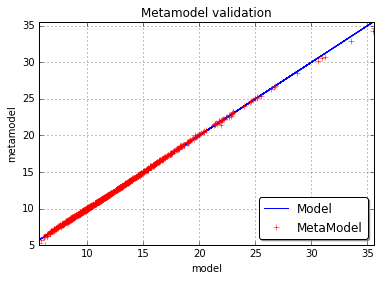

In [75]:
validation = ot.MetaModelValidation(input_sample, output_sample, metamodel)
print 'R2 : ', validation.computePredictivityFactor()
View(validation.drawValidation()).show()

### Superposition of the model and the metamodel in 1D cuts

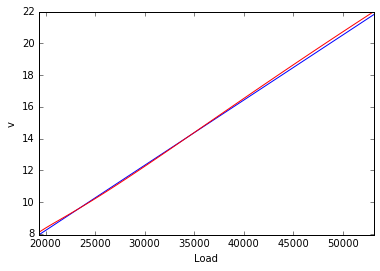

In [76]:
input_number = 0
input_margin = input_distribution.getMarginal(input_number)
model_cut = model.draw(input_number,
                       0,
                       input_distribution.getMean(),
                       input_margin.computeQuantile(.025)[0],
                       input_margin.computeQuantile(.975)[0],
                       100).getDrawable(0)
metamodel_cut = metamodel.draw(input_number,
                               0,
                               input_distribution.getMean(),
                               input_margin.computeQuantile(.025)[0],
                               input_margin.computeQuantile(.975)[0],
                               100).getDrawable(0)
graph = ot.Graph()
graph.add([model_cut, metamodel_cut])
graph.setColors(["blue", "red"])
graph.setLegends(["Model", "Metamodel"])
graph.setXTitle(input_margin.getDescription()[0])
graph.setYTitle(model.getOutputDescription()[0])
_ = View(graph)

Computation of the output mean and standard deviation from the chaos coefficients

## Use chaos for surrogate-based statistical analyses

First let's make a random vector out of the polynomial chaos metamodel.

In [77]:
chaos_based_output_random_vector = ot.FunctionalChaosRandomVector(PCE_result)

### Compute moments

In [78]:
print("Mean: %.2f" % chaos_based_output_random_vector.getMean()[0])

Mean: 13.83


### Computation of the Sobol indices from the chaos coefficients

In [79]:
for i in range(input_distribution.getDimension()):
    print "First-order Sobol index for %s is %.2f" % (
        input_distribution.getDescription()[i], chaos_based_output_random_vector.getSobolIndex(i))

First-order Sobol index for Load is 0.75
First-order Sobol index for Young modulus is 0.16
First-order Sobol index for Length is 0.02
First-order Sobol index for Inertia is 0.05


In [80]:
for i in range(input_distribution.getDimension()):
    print "Total-order Sobol index for %s is %.2f" % (
        input_distribution.getDescription()[i], chaos_based_output_random_vector.getSobolTotalIndex(i))

Total-order Sobol index for Load is 0.77
Total-order Sobol index for Young modulus is 0.17
Total-order Sobol index for Length is 0.02
Total-order Sobol index for Inertia is 0.06


### Reliability analysis using a (large) Monte Carlo sample of the chaos approximation

In [81]:
event = ot.Event(chaos_based_output_random_vector, ot.Greater(), 30.) 
event.setName("Deviation > %s cm" % event.getThreshold())

### PDF and CDF approximations

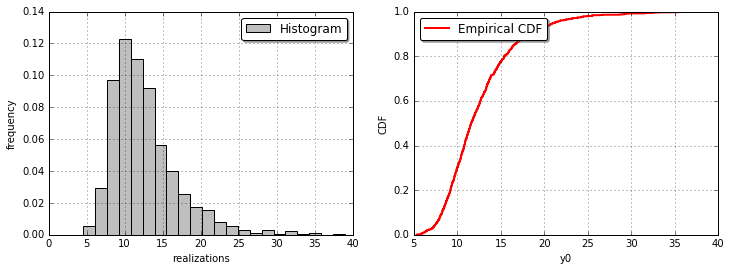

In [82]:
sample = chaos_based_output_random_vector.getSample(1000)
fig = pl.figure(figsize=(12, 4))
ax_pdf = fig.add_subplot(1, 2, 1)
hist_E = ot.VisualTest_DrawHistogram(sample)
hist_E.setColors(["gray"])
hist_E.setLegends(["Histogram"])
_ = View(hist_E, figure=fig, axes=[ax_pdf])
ax_cdf = fig.add_subplot(1, 2, 2)
ecdf_E = ot.VisualTest_DrawEmpiricalCDF(sample, sample.getMin()[0], sample.getMax()[0])
ecdf_E.setLegends(["Empirical CDF"])
_ = View(ecdf_E, figure=fig, axes=[ax_cdf])

In [83]:
MCS_algorithm = ot.MonteCarlo(event) 
MCS_algorithm.setMaximumOuterSampling(40000) 
MCS_algorithm.setBlockSize(1) 
MCS_algorithm.setMaximumCoefficientOfVariation(.1)
MCS_algorithm.run()
MCS_result = MCS_algorithm.getResult()

In [84]:
print "Proability estimate = %.2e" % MCS_result.getProbabilityEstimate() 
print "Coefficient of variation = %.2f" % MCS_result.getCoefficientOfVariation()
print "95%% Confidence Interval = [%.2e, %.2e]" % (MCS_result.getProbabilityEstimate() - .5 * MCS_result.getConfidenceLength(0.95),
                                                   MCS_result.getProbabilityEstimate() + .5 * MCS_result.getConfidenceLength(0.95))

Proability estimate = 5.26e-03
Coefficient of variation = 0.10
95% Confidence Interval = [4.23e-03, 6.29e-03]


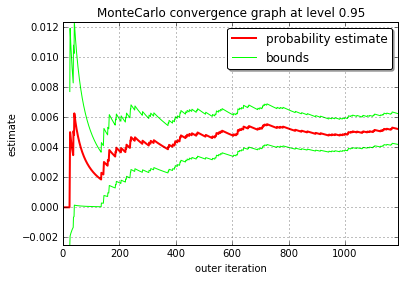

In [85]:
_ = View(MCS_algorithm.drawProbabilityConvergence(.95))